# Lesson 5 Homework
Rob Lisy

### Description
Rooney's client is a tech-manufacturing startup working on a number of automated detection devices for the medical and construction industries. Among the auto-detection devices is a reader that looks at possible carcinoma tissue samples to classify the sample as either benign or malignant. Rooney asks you for help in developing a better algorithm than the current classifier, perhaps a decision tree can help.

For this assignment, you will be designing an experiment using decision tree classifiers for the detection of breast cancer and comparing the accuracy.

### Attributes:
    - Sample code number: id number
    - Class (4 for malignant, 2 for benign)
    - Clump Thickness: 1 - 10
    - Uniformity of Cell Size: 1 - 10
    - Uniformity of Cell Shape: 1 - 10
    - Marginal Adhesion: 1 - 10
    - Single Epithelial Cell Size: 1 - 10
    - Bare Nuclei: 1 - 10
    - Bland Chromatin: 1 - 10
    - Normal Nucleoli: 1 - 10
    - Mitosis: 1-10

Note 1: These are all integer values. The features that are 1-10 represent the rank or binning of numeric features. Because of this they can be treated "as is" and don't require further normalization or even one-hot encoding.
    
    
Note 2: The correct data set has 699 rows, careful of garbage!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

file = 'WI_Breast_Cancer.csv'

# useful option, the `comment=` allows us to skip loading lines which start with a comment
df = pd.read_csv('WI_Breast_Cancer.csv', 
                comment='#', header=None)
print(f"Shape: {df.shape}")

# rename columns
df.columns = ['ID', 'class', 'clump_thickness', 'uniformity_of_cell_size', 'uniformity_of_cell_shape',
             'marginal_adhesion', 'single_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitosis']

# remap classes from 4/2 to 'malignant'/'benign'
outcomes = {4:'malignant', 2:'benign'}
df['class'] = df['class'].map(outcomes)
df.head()

Shape: (699, 11)


,ID,class,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis
0,1000025,benign,5,1,1,1,2,1,3,1,1
1,1002945,benign,5,4,4,5,7,10,3,2,1
2,1015425,benign,3,1,1,1,2,2,3,1,1
3,1016277,benign,6,8,8,1,3,4,3,7,1
4,1017023,benign,4,1,1,3,2,1,3,1,1


In [2]:
df.dtypes

ID                           int64
class                       object
clump_thickness              int64
uniformity_of_cell_size      int64
uniformity_of_cell_shape     int64
marginal_adhesion            int64
single_cell_size             int64
bare_nuclei                  int64
bland_chromatin              int64
normal_nucleoli              int64
mitosis                      int64
dtype: object

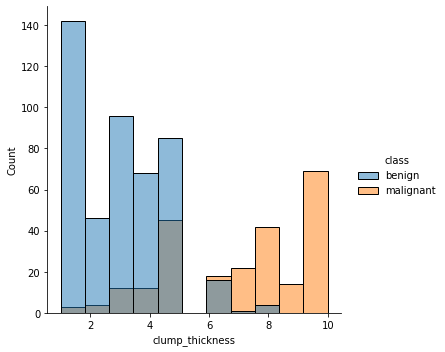

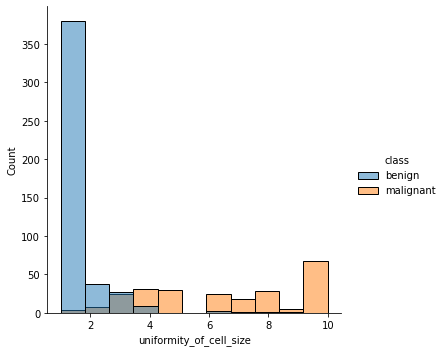

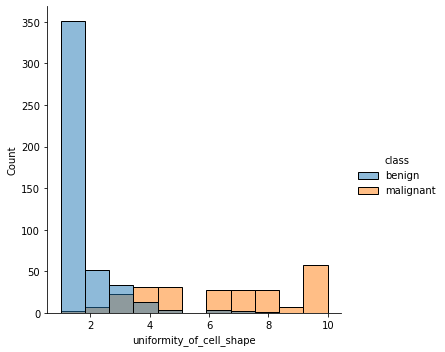

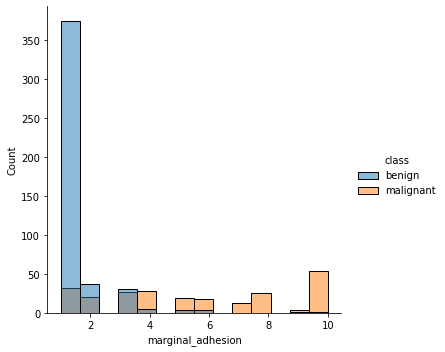

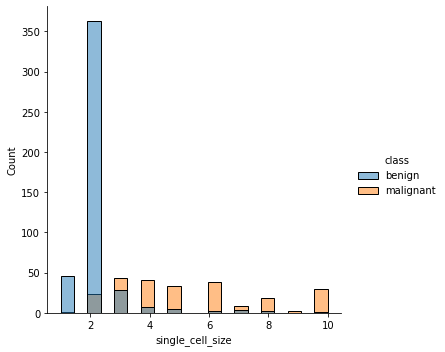

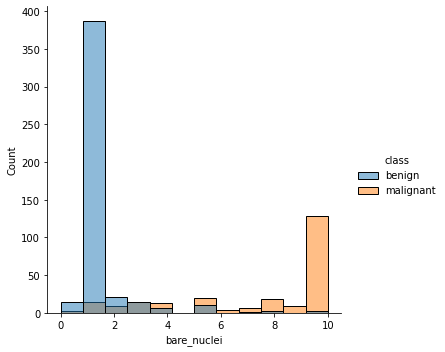

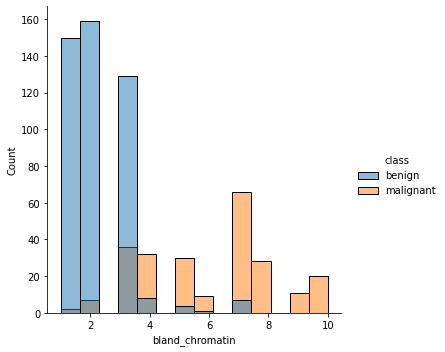

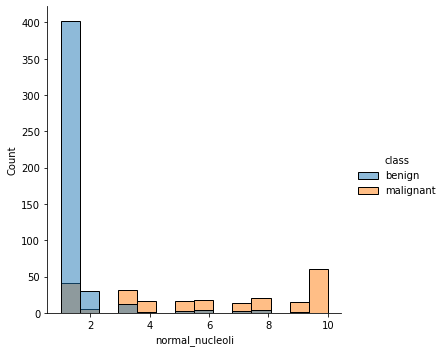

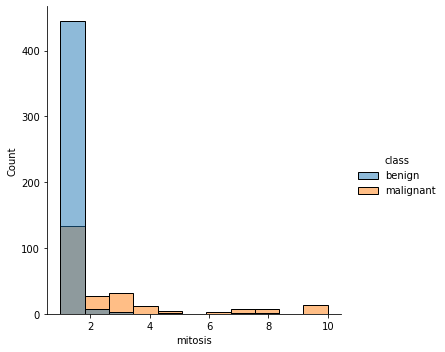

In [3]:
# Do some plotting

plot_cols = ['clump_thickness', 'uniformity_of_cell_size', 'uniformity_of_cell_shape',
             'marginal_adhesion', 'single_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitosis']
for c in plot_cols:
    g = sns.displot(data=df, x=c, hue="class")
    plt.show();

# Decision Trees

Now that we have the data loaded and we've looked at the attributes, we are going to make a few decision trees and evaluate the performance of them.

In [4]:
# Let's get cracking... split the data into a test/train set
X = df.drop(columns = ["ID", "class"])
Y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 32768)

def plot_cf_matrix(cm):
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show();

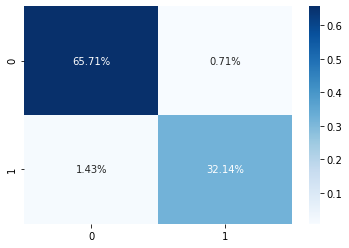

In [5]:
# make decision trees - one entropy based, one Gini based...
decision_tree_entropy = DecisionTreeClassifier(criterion = 'entropy')
decision_tree_entropy.fit(X_train, y_train)
y_pred_test = decision_tree_entropy.predict(X_test)

plot_cf_matrix(confusion_matrix(y_test, y_pred_test))

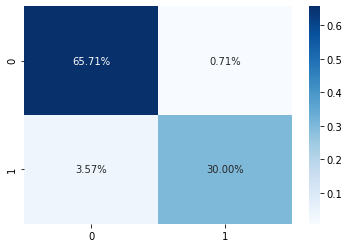

In [6]:
# Gini based model...
decision_tree_gini = DecisionTreeClassifier(criterion = 'gini')
decision_tree_gini.fit(X_train, y_train)
y_pred_test = decision_tree_gini.predict(X_test)


plot_cf_matrix(confusion_matrix(y_test, y_pred_test))

# Performance

The entropy based model outperforms the Gini based model, ever so slightly. The Gini based model has fewer false positives, but doesn't predict a few folks who have cancer. That's probably the worst outcome here (and one we can tune our model around later).

Article on Gini vs entropy split:
https://github.com/rasbt/python-machine-learning-book/blob/master/faq/decision-tree-binary.md


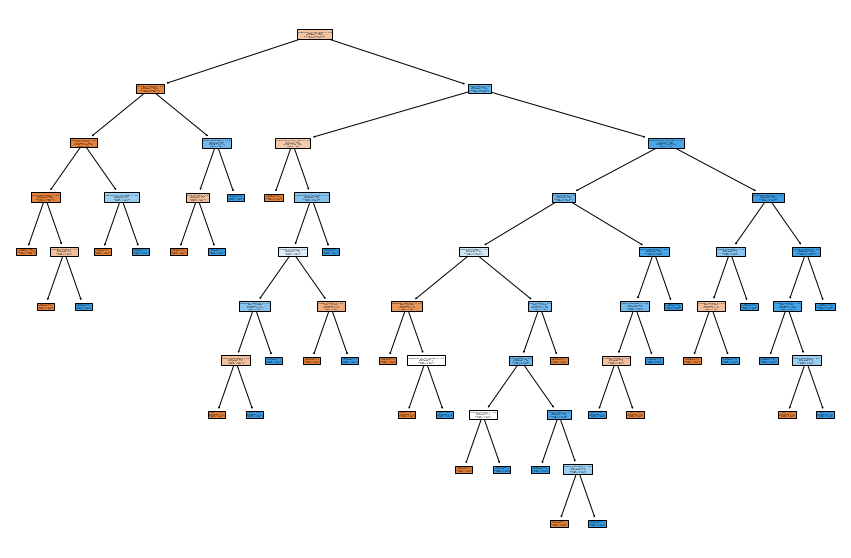

In [7]:
# and plot the 2 trees
fig = plt.figure(figsize=(15, 10))
feature_names = X_train.columns.values.tolist()
_ = tree.plot_tree(decision_tree_gini, feature_names=feature_names,
                   class_names=['No', 'Yes'], filled=True)

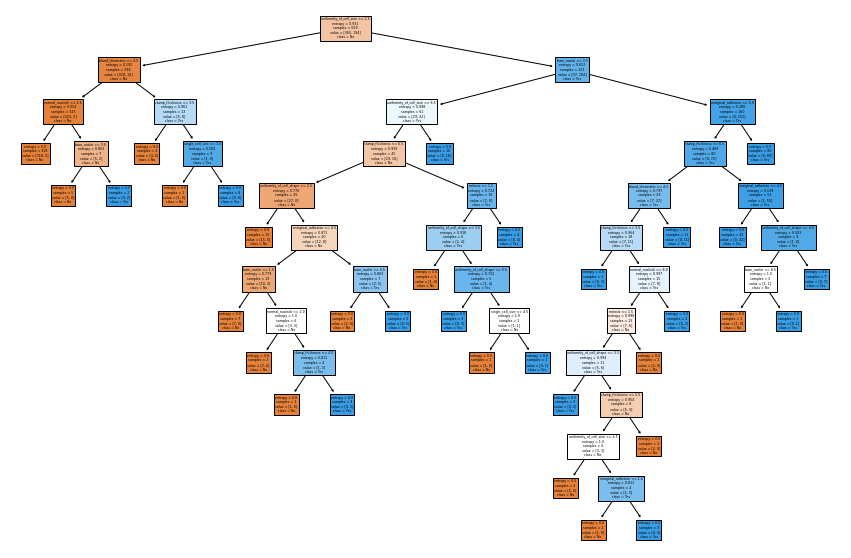

In [8]:
fig = plt.figure(figsize=(15, 10))
feature_names = X_train.columns.values.tolist()
_ = tree.plot_tree(decision_tree_entropy, feature_names=feature_names,
                   class_names=['No', 'Yes'], filled=True)

# Feature importance

Let's check and see if the Gini and entropy methods agree on feature importance...

In [9]:
features_importances = decision_tree_entropy.tree_.compute_feature_importances()

for feature_name, importance in zip(feature_names, features_importances):
    print(f'Col: {feature_name}, Entropy Importance: {importance:.3f}')

Col: clump_thickness, Entropy Importance: 0.058
Col: uniformity_of_cell_size, Entropy Importance: 0.640
Col: uniformity_of_cell_shape, Entropy Importance: 0.033
Col: marginal_adhesion, Entropy Importance: 0.033
Col: single_cell_size, Entropy Importance: 0.013
Col: bare_nuclei, Entropy Importance: 0.107
Col: bland_chromatin, Entropy Importance: 0.078
Col: normal_nucleoli, Entropy Importance: 0.031
Col: mitosis, Entropy Importance: 0.007


In [10]:
features_importances = decision_tree_gini.tree_.compute_feature_importances()

for feature_name, importance in zip(feature_names, features_importances):
    print(f'Col: {feature_name}, Gini Importance: {importance:.3f}')

Col: clump_thickness, Gini Importance: 0.042
Col: uniformity_of_cell_size, Gini Importance: 0.740
Col: uniformity_of_cell_shape, Gini Importance: 0.004
Col: marginal_adhesion, Gini Importance: 0.013
Col: single_cell_size, Gini Importance: 0.010
Col: bare_nuclei, Gini Importance: 0.100
Col: bland_chromatin, Gini Importance: 0.013
Col: normal_nucleoli, Gini Importance: 0.077
Col: mitosis, Gini Importance: 0.000


# Feature Importance

Generally both Gini and entropy agree that the most important features are:
- uniformity of cell size
- bare nuclei

There are others that follow, but it's good that both models share general agreement on order AND scale.

------------
# Hyperparameter tuning

At this point we've just made 2 simple trees, both with the same max depth and number of components. We can use a Grid Search to explore the hyper parameter space and tune them to try and find the best model fit.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import graphviz

In [12]:
# Find the best Gini...
param_grid = {
    'criterion': ['gini'],
    'max_depth': range(1, 31),
    'min_samples_split': range(1, 11),
}
dt = DecisionTreeClassifier()
gscv = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
)
best_gini = gscv.fit(X_train, y_train)

# and the best entropy
param_grid = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'min_samples_split': range(1, 11),
}
dt = DecisionTreeClassifier()
gscv = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
)
best_entropy = gscv.fit(X_train, y_train)

In [13]:
# What are the best hyperparameter settings for both?
print(f"The best Gini parameters are {best_gini.best_params_}")
print(f"The best entropy parameters are {best_entropy.best_params_}")

The best Gini parameters are {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4}
The best entropy parameters are {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 3}


# Model Choice

We now have 2 "best" models, one each for Gini and entropy based decision trees. Let's compare them against each other to help us choose which of these we should operationalize in the field. Of concern to us will be the error rates for these models, especially in the cases where the model:
- doesn't detect a cancer which exists (false negative)
- detects a cancer which doesn't exist (false positive)

All other things being equal, we should heavily weight against a model which generates false positives, since having undetected breast cancer is a very bad thing. We should also try and limit false positives, since they generate harmful and needless medical invervention.

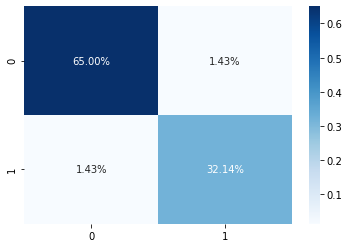

In [14]:
# What's the accuracy of these best models?
y_pred_test = best_gini.predict(X_test)

plot_cf_matrix(confusion_matrix(y_test, y_pred_test))

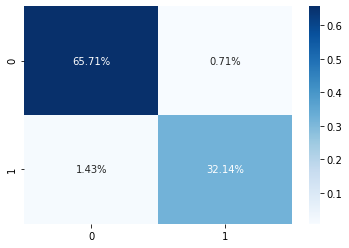

In [15]:
y_pred_test = best_entropy.predict(X_test)

plot_cf_matrix(confusion_matrix(y_test, y_pred_test))

# Feature importance

For the best models, let's look at feature importance now.

In [16]:
# make a Gini with the best features...
final_gini = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2)
final_gini.fit(X_train, y_train)

features_importances = final_gini.tree_.compute_feature_importances()

for feature_name, importance in zip(feature_names, features_importances):
    print(f'Col: {feature_name}, Gini Importance: {importance:.2f}')

Col: clump_thickness, Gini Importance: 0.04
Col: uniformity_of_cell_size, Gini Importance: 0.78
Col: uniformity_of_cell_shape, Gini Importance: 0.01
Col: marginal_adhesion, Gini Importance: 0.01
Col: single_cell_size, Gini Importance: 0.01
Col: bare_nuclei, Gini Importance: 0.09
Col: bland_chromatin, Gini Importance: 0.00
Col: normal_nucleoli, Gini Importance: 0.05
Col: mitosis, Gini Importance: 0.00


In [17]:
final_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=4)
final_entropy.fit(X_train, y_train)

features_importances = final_entropy.tree_.compute_feature_importances()

for feature_name, importance in zip(feature_names, features_importances):
    print(f'Col: {feature_name}, entropy Importance: {importance:.2f}')

Col: clump_thickness, entropy Importance: 0.02
Col: uniformity_of_cell_size, entropy Importance: 0.77
Col: uniformity_of_cell_shape, entropy Importance: 0.00
Col: marginal_adhesion, entropy Importance: 0.02
Col: single_cell_size, entropy Importance: 0.00
Col: bare_nuclei, entropy Importance: 0.09
Col: bland_chromatin, entropy Importance: 0.08
Col: normal_nucleoli, entropy Importance: 0.03
Col: mitosis, entropy Importance: 0.00


# Intrepretation

The feature importance of the best Gini and entropy models are again very similar. Gini weights the `uniformity of cell size` and `bare nucleoli` even more heavily than entropy.

# Summary

In this instance I would chose the best Gini model, since both models have the same error rates around missing cancer cases which do exist (1.4%), but the Gini model has fewer false positives (0%!). Let's visualize the final Gini model.

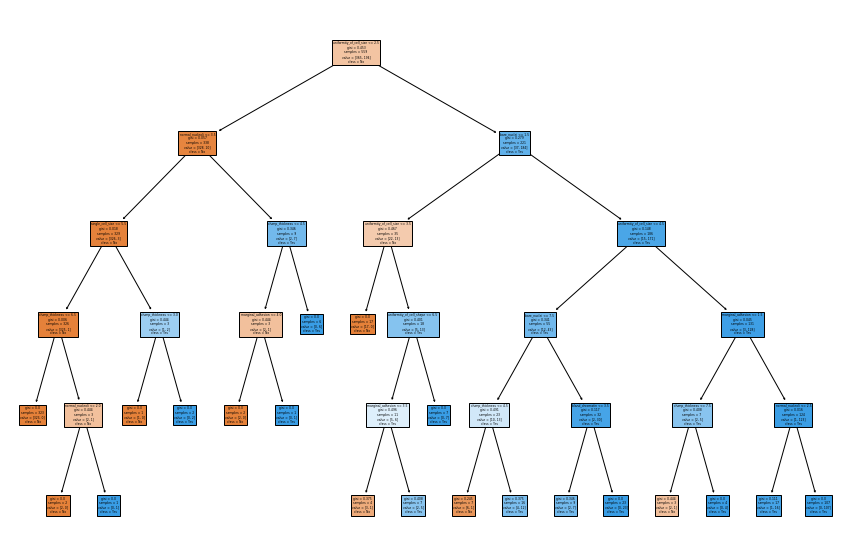

In [22]:
fig = plt.figure(figsize=(15, 10))
feature_names = X_train.columns.values.tolist()

_ = tree.plot_tree(final_gini, feature_names=feature_names,
                   class_names=['No', 'Yes'], filled=True)